In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms

train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure", 0.2, 12)

Found 856 files belonging to 2 classes.
Using 685 files for training.
Using 171 files for validation.
label names: ['no_queen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (12, 4000)
Example label shape: (12,)


2024-03-23 17:24:06.219145: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-23 17:24:06.219169: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-23 17:24:06.219175: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-23 17:24:06.219202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-23 17:24:06.219220: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [2]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Initial models (OSBH)

## MFCCs

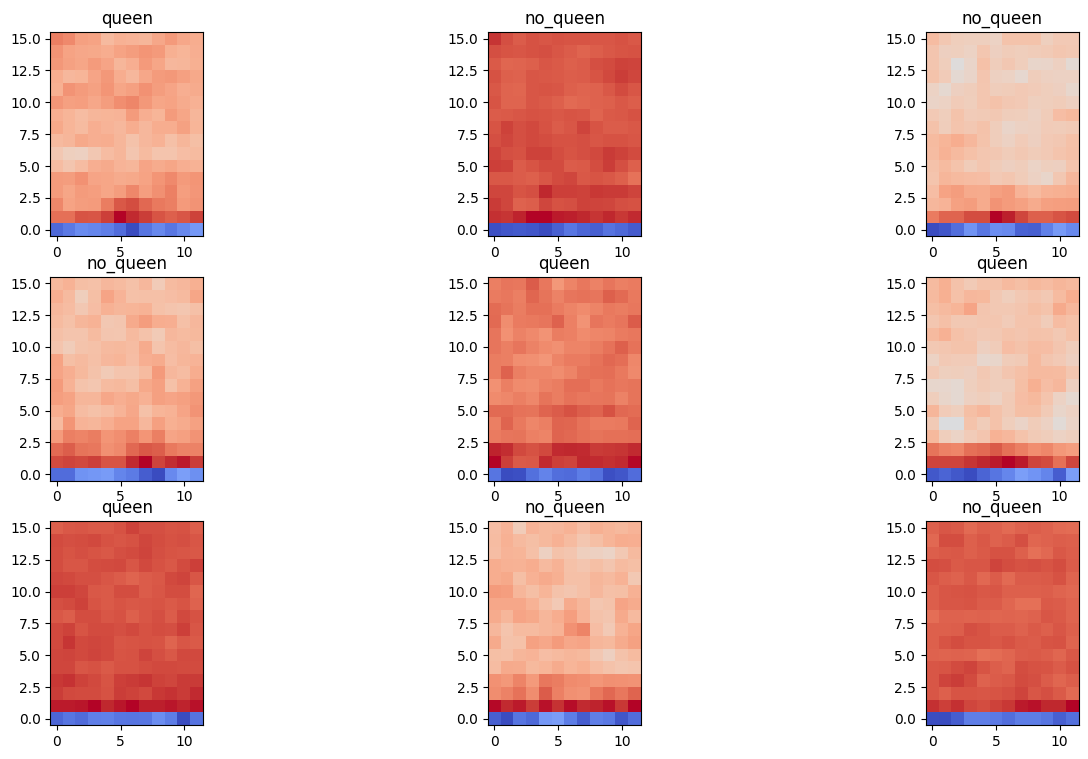

In [3]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [4]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 16, 1])

In [5]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [MFCCs] Sequential model

2024-03-23 17:24:07.756628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2024-03-23 17:24:08.917572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


58/58 [==============================] - 6s 78ms/step - loss: 0.4844 - accuracy: 0.7752 - val_loss: 0.2596 - val_accuracy: 0.9123
Epoch 2/20
58/58 [==============================] - 1s 10ms/step - loss: 0.2542 - accuracy: 0.9343 - val_loss: 0.2112 - val_accuracy: 0.9298
Epoch 3/20
58/58 [==============================] - 1s 10ms/step - loss: 0.2158 - accuracy: 0.9401 - val_loss: 0.2005 - val_accuracy: 0.9298
Epoch 4/20
58/58 [==============================] - 1s 10ms/step - loss: 0.1658 - accuracy: 0.9533 - val_loss: 0.2452 - val_accuracy: 0.9298
Epoch 5/20
58/58 [==============================] - 1s 10ms/step - loss: 0.1755 - accuracy: 0.9489 - val_loss: 0.1850 - val_accuracy: 0.9591
Epoch 6/20
58/58 [==============================] - 1s 10ms/step - loss: 0.0664 - accuracy: 0.9766 - val_loss: 0.2728 - val_accuracy: 0.9181
Epoch 7/20
58/58 [==============================] - 1s 10ms/step - loss: 0.0925 - accuracy: 0.9664 - val_loss: 0.3232 - val_accuracy: 0.9240


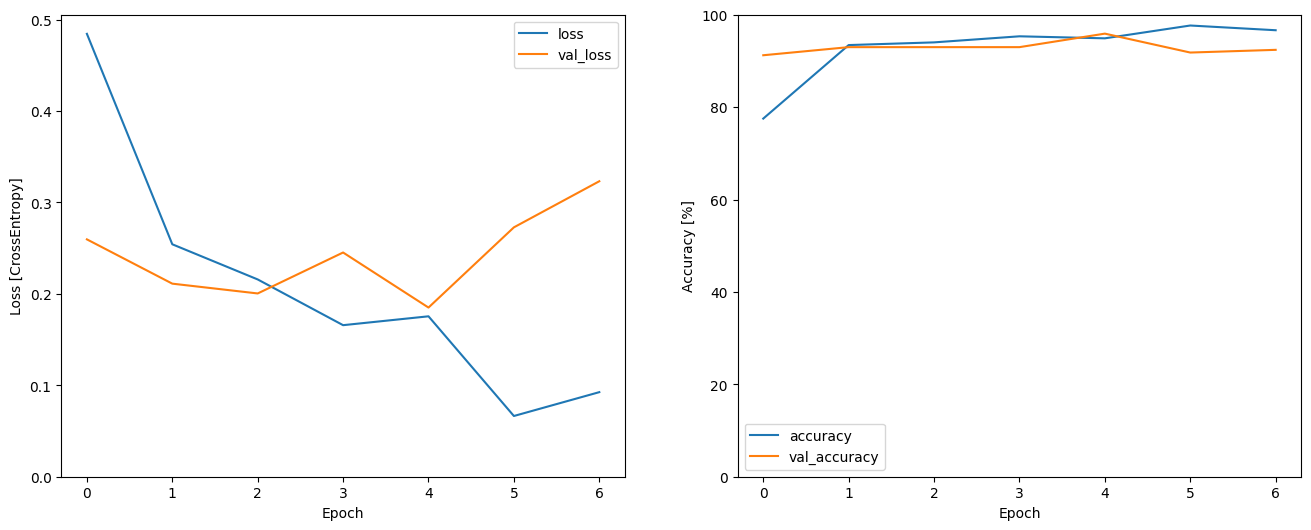

In [6]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [MFCCs] Convolutional model (mini)

Epoch 1/20
58/58 [==============================] - 2s 28ms/step - loss: 0.6148 - accuracy: 0.6496 - val_loss: 0.4967 - val_accuracy: 0.8246
Epoch 2/20
58/58 [==============================] - 0s 5ms/step - loss: 0.4088 - accuracy: 0.8350 - val_loss: 0.3405 - val_accuracy: 0.8480
Epoch 3/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3068 - accuracy: 0.8949 - val_loss: 0.2624 - val_accuracy: 0.9064
Epoch 4/20
58/58 [==============================] - 0s 5ms/step - loss: 0.3045 - accuracy: 0.8745 - val_loss: 0.2853 - val_accuracy: 0.8830
Epoch 5/20
58/58 [==============================] - 0s 5ms/step - loss: 0.2486 - accuracy: 0.9212 - val_loss: 0.2331 - val_accuracy: 0.9123
Epoch 6/20
58/58 [==============================] - 0s 5ms/step - loss: 0.2227 - accuracy: 0.9212 - val_loss: 0.2186 - val_accuracy: 0.9064
Epoch 7/20
58/58 [==============================] - 0s 5ms/step - loss: 0.2023 - accuracy: 0.9314 - val_loss: 0.2054 - val_accuracy: 0.9357
Epoch 8/20
58/58 [=

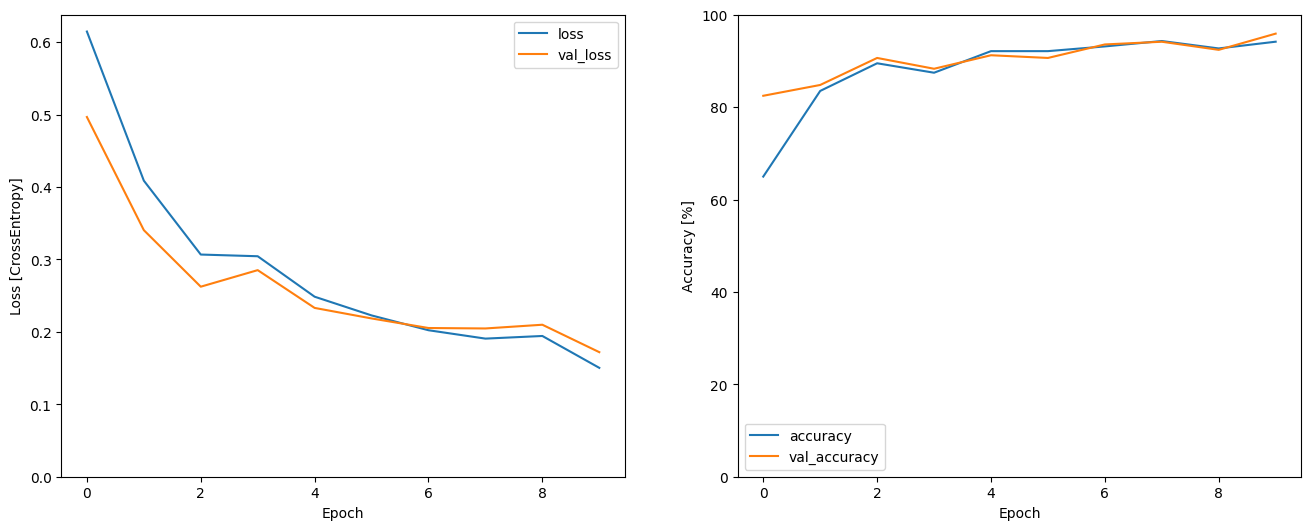

In [7]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Spectrograms

(118, 129, 1)


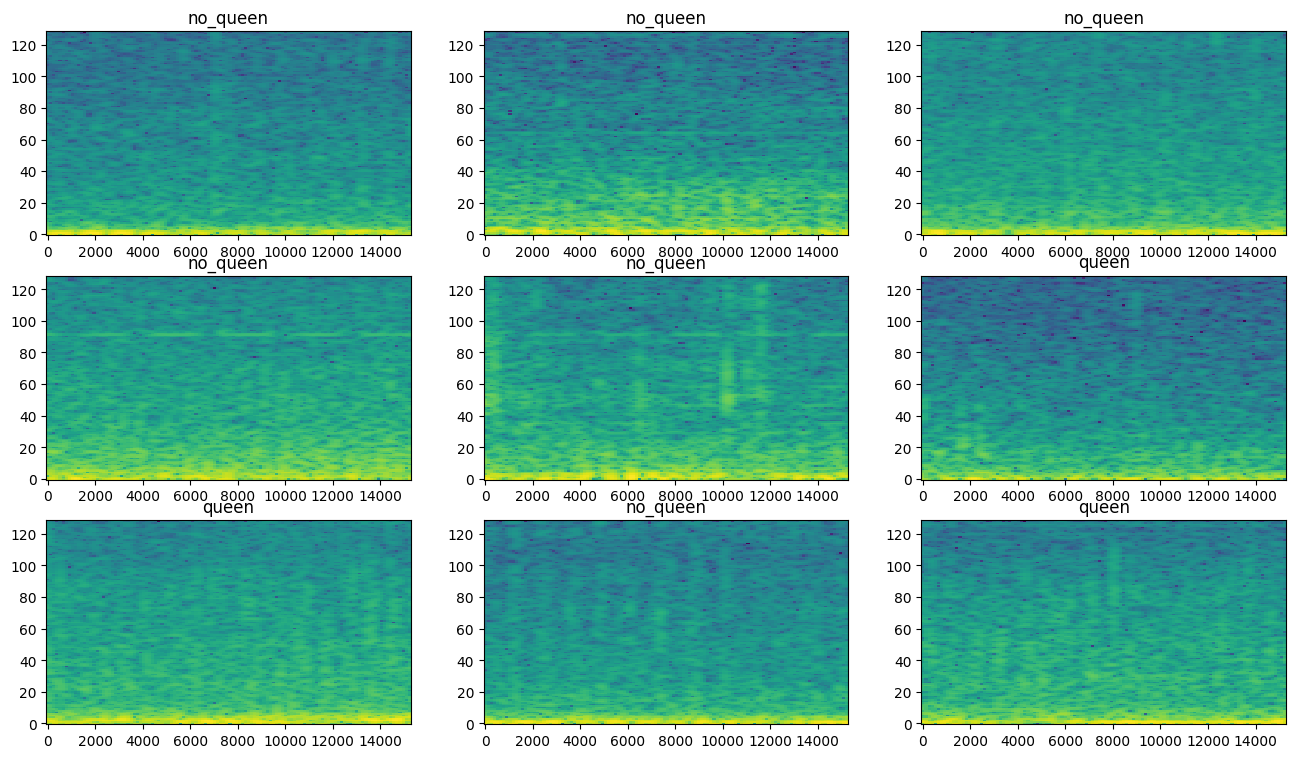

In [8]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [9]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Spec] Sequential model

Epoch 1/20
58/58 [==============================] - 1s 14ms/step - loss: 0.6161 - accuracy: 0.6146 - val_loss: 0.5347 - val_accuracy: 0.7310
Epoch 2/20
58/58 [==============================] - 1s 10ms/step - loss: 0.4283 - accuracy: 0.7985 - val_loss: 0.2756 - val_accuracy: 0.9240
Epoch 3/20
58/58 [==============================] - 1s 10ms/step - loss: 0.2580 - accuracy: 0.9007 - val_loss: 0.2572 - val_accuracy: 0.9240
Epoch 4/20
58/58 [==============================] - 1s 10ms/step - loss: 0.2297 - accuracy: 0.9095 - val_loss: 0.1632 - val_accuracy: 0.9591
Epoch 5/20
58/58 [==============================] - 1s 11ms/step - loss: 0.1744 - accuracy: 0.9372 - val_loss: 0.1843 - val_accuracy: 0.9532
Epoch 6/20
58/58 [==============================] - 1s 10ms/step - loss: 0.1657 - accuracy: 0.9387 - val_loss: 0.1537 - val_accuracy: 0.9532


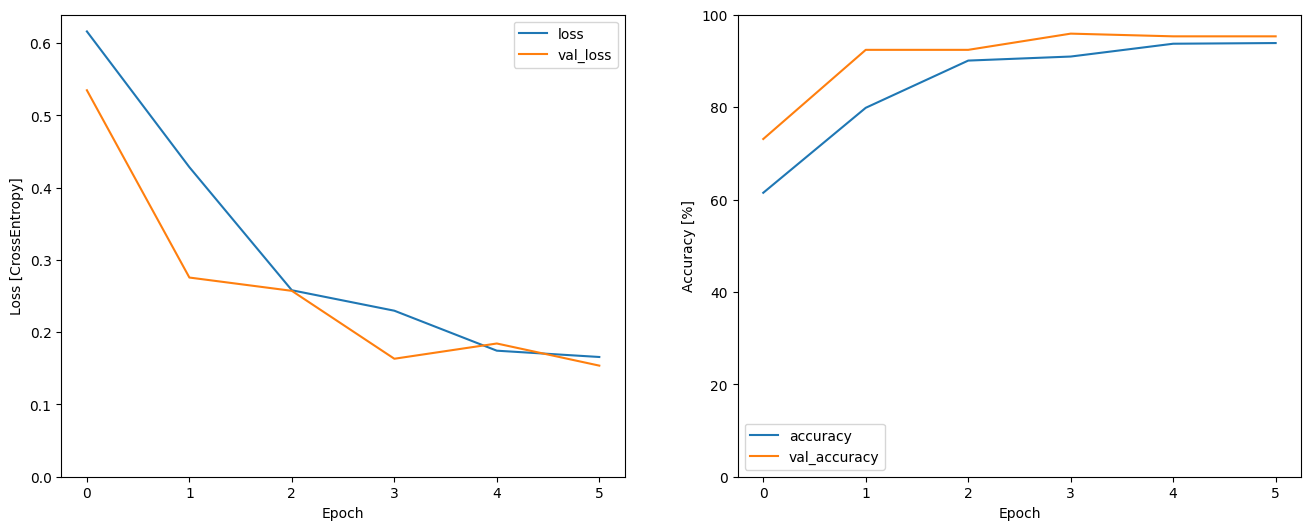

In [10]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Spec] Convolutional model

Epoch 1/20
58/58 [==============================] - 2s 31ms/step - loss: 0.4834 - accuracy: 0.7591 - val_loss: 0.2026 - val_accuracy: 0.9357
Epoch 2/20
58/58 [==============================] - 1s 13ms/step - loss: 0.2397 - accuracy: 0.9066 - val_loss: 0.1615 - val_accuracy: 0.9532
Epoch 3/20
58/58 [==============================] - 1s 10ms/step - loss: 0.2201 - accuracy: 0.9124 - val_loss: 0.1452 - val_accuracy: 0.9591
Epoch 4/20
58/58 [==============================] - 1s 11ms/step - loss: 0.1802 - accuracy: 0.9343 - val_loss: 0.1363 - val_accuracy: 0.9591
Epoch 5/20
58/58 [==============================] - 1s 13ms/step - loss: 0.1547 - accuracy: 0.9445 - val_loss: 0.1582 - val_accuracy: 0.9474
Epoch 6/20
58/58 [==============================] - 1s 14ms/step - loss: 0.1420 - accuracy: 0.9460 - val_loss: 0.2268 - val_accuracy: 0.9532


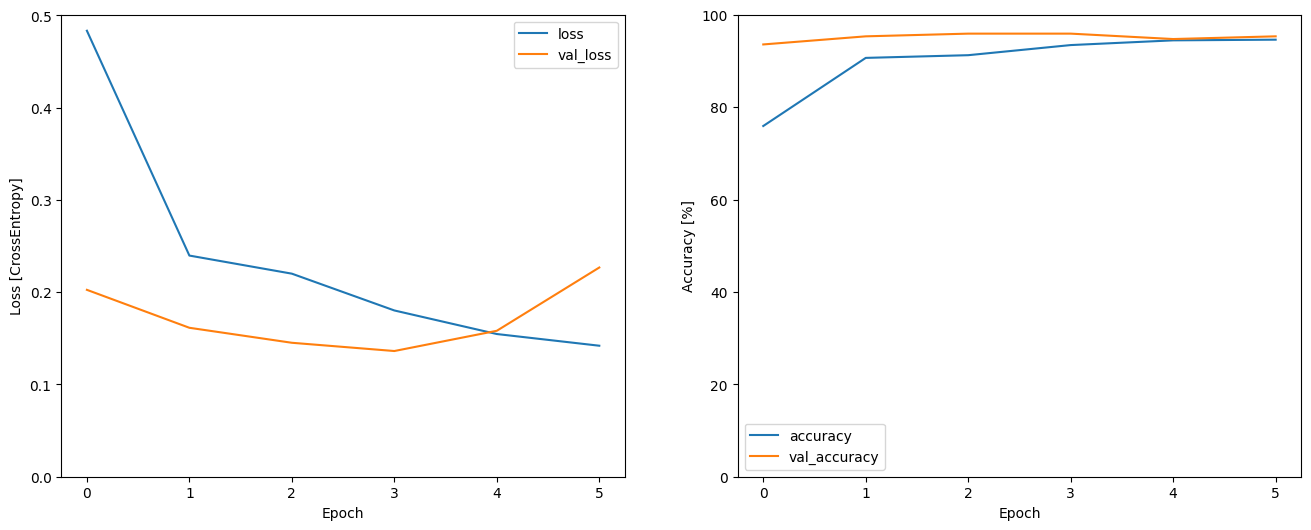

In [11]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Save models

In [12]:
model_mfcc_seq.save('models/mfcc_seq.h5')
model_mfcc_conv.save('models/mfcc_conv_mini.h5')
model_spec_seq.save('models/spec_seq.h5')
model_spec_conv.save('models/spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
